In [56]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
opj = os.path.join
CODE_DIR = os.path.abspath('../..')
sys.path.append(os.path.abspath('../python'))
sys.path.append(opj(CODE_DIR, 'EPypes'))
sys.path.append(opj(CODE_DIR, 'kacomponents'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [58]:
import cv2
from skimage import measure, feature, util, draw, transform, filters
from sklearn import model_selection, svm, naive_bayes, tree, ensemble, neighbors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
import math
import nxpd

nxpd.nxpdParams['show'] = 'ipynb'

In [59]:
import kavision
import mlearn
import ghelpers as gh
import imutils

from epypes.compgraph import CompGraph, CompGraphRunner
from epypes.pipeline import Pipeline

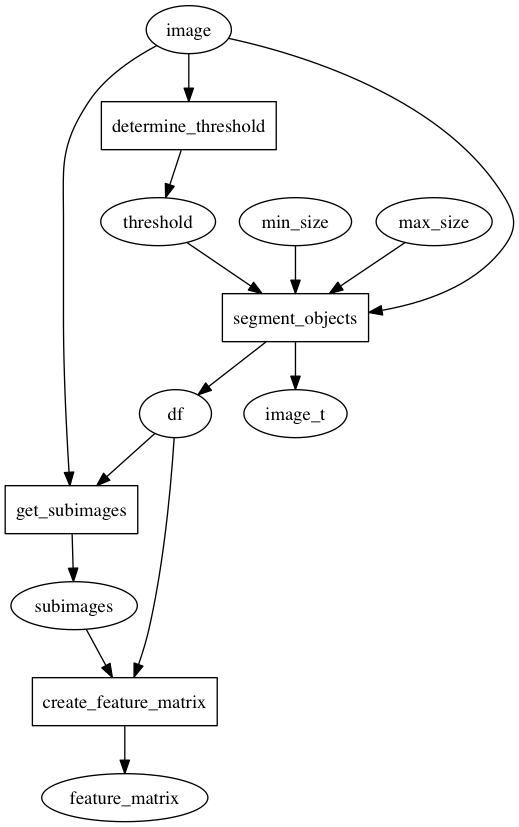

In [60]:
cg_features = CompGraph(
    
    func_dict = {
        'determine_threshold': filters.threshold_otsu,
        'segment_objects': kavision.segment_good_objects,
        'get_subimages': imutils.get_subimages,
        'create_feature_matrix': mlearn.radial_profiles_feature_matrix
    }, 
    
    func_io = {
        'determine_threshold': ('image', 'threshold'),
        'segment_objects': (('image', 'threshold', 'min_size', 'max_size'), ('df', 'image_t')),
        'get_subimages': (('image', 'df'), 'subimages'),
        'create_feature_matrix': (('subimages', 'df'), 'feature_matrix')
        
    }
)

nxpd.draw(cg_features.to_networkx())

In [61]:
imdir = opj(CODE_DIR, 'DATA/IMG/ML_1')
imfiles = ('ml_small_incorrect_lightoff.png', 'ml_small_correct_lightoff.png')

im0 = imutils.open_image(opj(imdir, imfiles[0]))
im1 = imutils.open_image(opj(imdir, imfiles[1]))

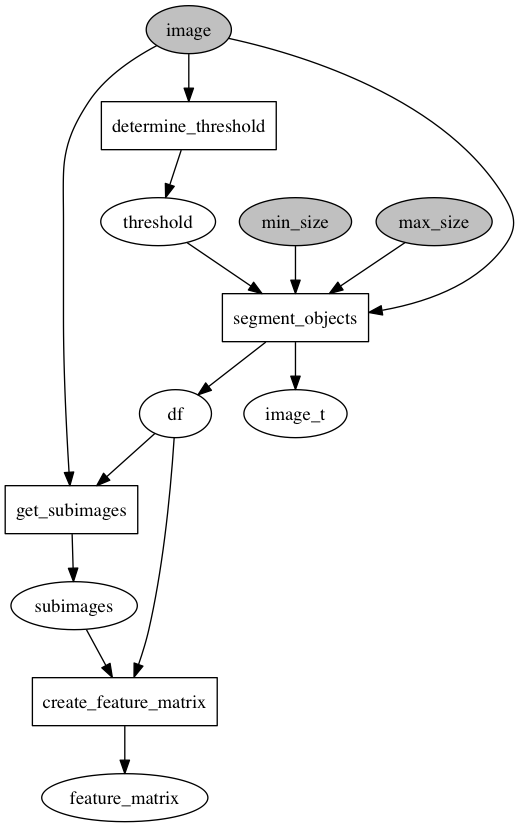

In [62]:
runner_features_0 = CompGraphRunner(cg_features, frozen_tokens={'image': im0, 'min_size': 40, 'max_size': 50})
runner_features_1 = CompGraphRunner(cg_features, frozen_tokens={'image': im1, 'min_size': 40, 'max_size': 50})

nxpd.draw(runner_features_0.token_manager.to_networkx())

In [63]:
runner_features_0.run()
runner_features_1.run()

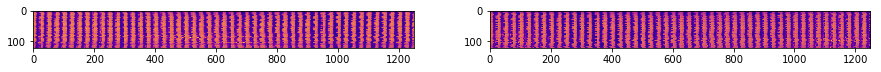

In [64]:
plt.figure(figsize=(15, 30))
plt.subplot(121)
plt.imshow(runner_features_0.token_value('feature_matrix'), cmap='plasma')
plt.subplot(122)
plt.imshow(runner_features_1.token_value('feature_matrix'), cmap='plasma')

In [65]:
print('Number of feature vectors for y=0:', runner_features_0.token_value('feature_matrix').shape[0])
print('Number of feature vectors for y=1:', runner_features_1.token_value('feature_matrix').shape[0])

Number of feature vectors for y=0: 122
Number of feature vectors for y=1: 121


In [66]:
def prepare_X_y(fmat_0, fmat_1):
    
    total_num = min(fmat_0.shape[0], fmat_1.shape[0])
    
    X = np.vstack((fmat_0[:total_num,:], fmat_1[:total_num,:]))
    y = np.hstack((np.zeros(total_num), np.ones(total_num)))
    
    return X, y

In [67]:
X, y = prepare_X_y(runner_features_0.token_value('feature_matrix'), runner_features_1.token_value('feature_matrix'))

In [68]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)

In [69]:
def get_classifier_name(clf):
    return str(clf.__class__)[1:-1].split()[1][1:-1].split('.')[-1]

In [70]:
classifiers = [  
    svm.SVC(gamma=0.001, C=100.),
    naive_bayes.MultinomialNB(),
    naive_bayes.GaussianNB(),
    tree.DecisionTreeClassifier(),
    ensemble.AdaBoostClassifier(),
    ensemble.RandomForestClassifier(),
    neighbors.KNeighborsClassifier()  
]

In [78]:
cv_scores = []
for cls in classifiers:
    current_scores = model_selection.cross_val_score(cls, X, y, cv=8)
    cv_scores.append(current_scores)

In [79]:
cv_scores_summary = pd.DataFrame(cv_scores, index=[get_classifier_name(cls) for cls in classifiers])
cv_scores_summary

,0,1,2,3,4,5,6,7
SVC,0.50000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
MultinomialNB,0.84375,0.966667,0.933333,1.000000,0.900000,0.900000,0.933333,1.000000
GaussianNB,0.50000,0.900000,0.966667,1.000000,0.966667,0.966667,0.966667,1.000000
DecisionTreeClassifier,0.40625,0.700000,0.866667,0.933333,0.866667,0.866667,0.966667,0.966667
AdaBoostClassifier,0.75000,0.966667,0.966667,1.000000,1.000000,1.000000,1.000000,0.966667
RandomForestClassifier,0.59375,0.866667,0.966667,1.000000,0.966667,1.000000,1.000000,0.933333
KNeighborsClassifier,0.53125,0.900000,0.933333,0.933333,0.866667,0.966667,0.900000,1.000000


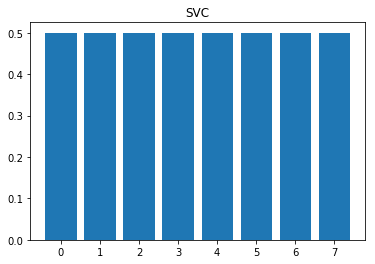

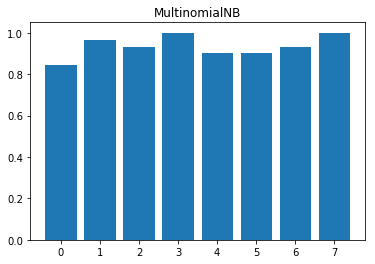

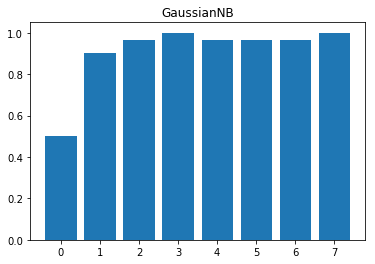

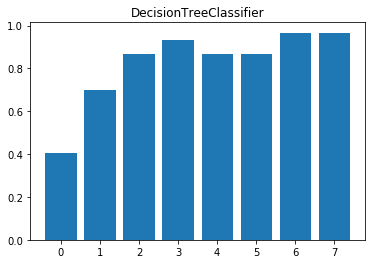

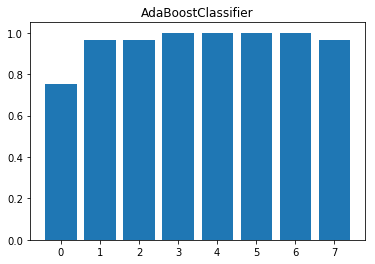

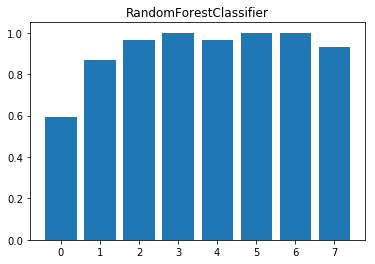

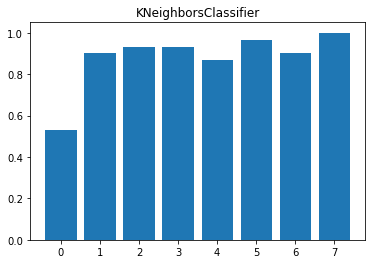

In [84]:
for cls, cls_scores in zip(classifiers, cv_scores):
    plt.figure()
    plt.bar(range(len(cls_scores)), cls_scores)
    cls_name = get_classifier_name(cls)
    plt.title(cls_name)